Starting data preprocessing...
Loading CIFAR-10 dataset...
Data preprocessing completed.
Splitting data into train and validation sets...

Data Distribution:
Training set - Cats: 4000, Dogs: 4000
Validation set - Cats: 1000, Dogs: 1000
Test set - Cats: 1000, Dogs: 1000

Data shapes:
Training data: (8000, 32, 32, 3)
Validation data: (2000, 32, 32, 3)
Test data: (2000, 32, 32, 3)

Starting model training...
Class weights - Cat: 1.0000, Dog: 1.0000
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.4898 - loss: 0.8227
Epoch 1: val_loss improved from inf to 0.70221, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 632ms/step - accuracy: 0.4899 - loss: 0.8224 - val_accuracy: 0.5000 - val_loss: 0.7022 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.4921 - loss: 0.7616
Epoch 2: val_loss improved from 0.70221 to 0.69177, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 640ms/step - accuracy: 0.4921 -

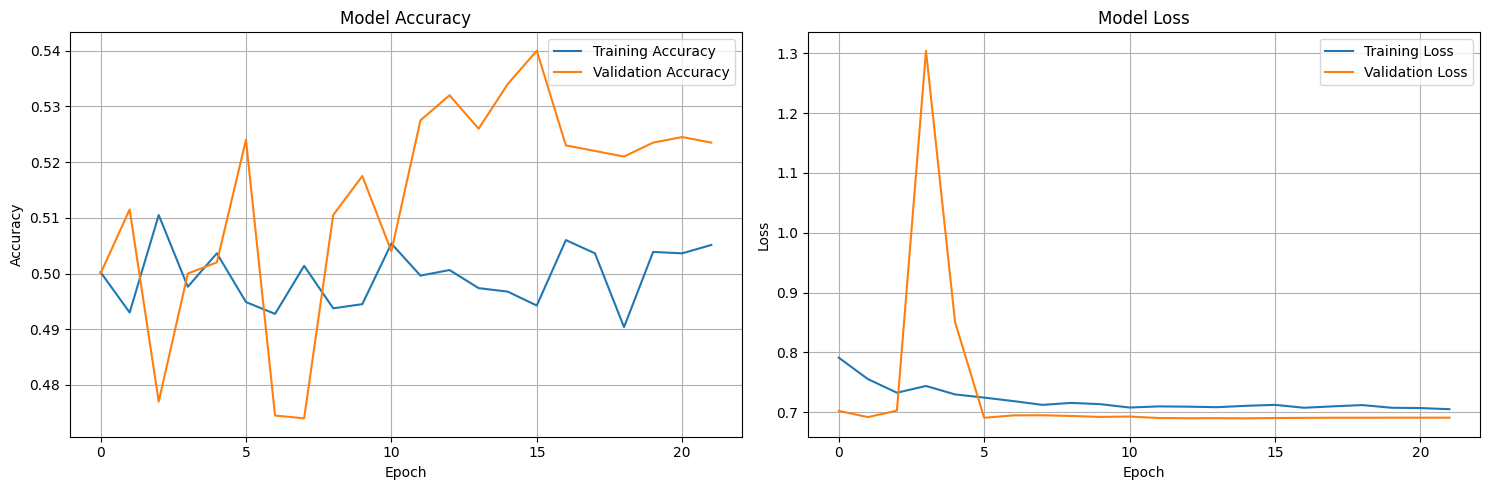


Evaluating model...
Generating predictions...
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step

Model Evaluation Metrics:
Accuracy: 0.5435
Precision: 0.5807
Recall: 0.3130
F1 Score: 0.4068


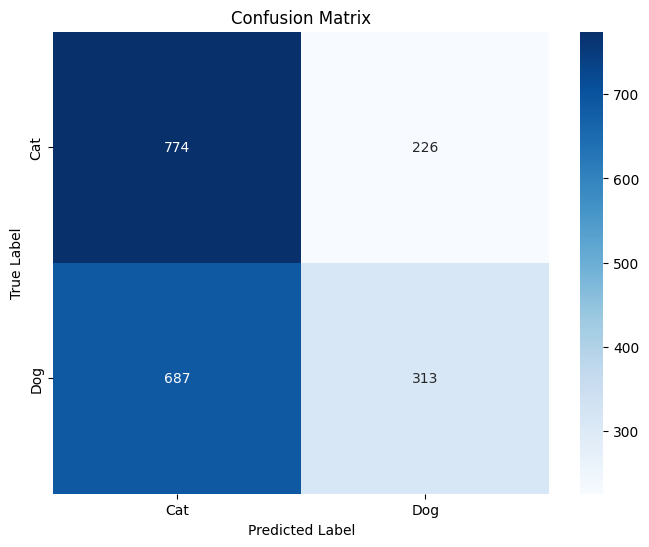

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Create directory for model checkpoints if it doesn't exist
os.makedirs('model_checkpoints', exist_ok=True)

def load_and_preprocess_data():
    """Load and preprocess CIFAR-10 dataset for cat/dog classification."""
    print("Loading CIFAR-10 dataset...")
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # Filter for cats (3) and dogs (5)
    train_mask = np.isin(y_train, [3, 5])
    test_mask = np.isin(y_test, [3, 5])

    x_train_filtered = x_train[train_mask.flatten()]
    y_train_filtered = y_train[train_mask]
    x_test_filtered = x_test[test_mask.flatten()]
    y_test_filtered = y_test[test_mask]

    # Convert labels to binary (Cat = 0, Dog = 1)
    y_train_binary = (y_train_filtered == 5).astype(np.int32)
    y_test_binary = (y_test_filtered == 5).astype(np.int32)

    # Standardization
    mean = np.mean(x_train_filtered, axis=(0, 1, 2))
    std = np.std(x_train_filtered, axis=(0, 1, 2))
    x_train_filtered = (x_train_filtered.astype('float32') - mean) / (std + 1e-7)
    x_test_filtered = (x_test_filtered.astype('float32') - mean) / (std + 1e-7)

    # Save mean and std for later use in deployment
    np.save('preprocessing_params.npy', {'mean': mean, 'std': std})
    print("Data preprocessing completed.")
    return x_train_filtered, y_train_binary, x_test_filtered, y_test_binary

def create_augmentation_layer():
    """Create data augmentation pipeline with reduced intensity."""
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.05),
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomBrightness(0.1)
    ])

def create_hybrid_model(input_shape=(32, 32, 3)):
    """Create hybrid CNN-MLP model with improved architecture."""
    inputs = Input(shape=input_shape)

    # Data Augmentation
    aug = create_augmentation_layer()(inputs)

    # First CNN block
    x = layers.Conv2D(32, 3, padding='same')(aug)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Second CNN block
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Third CNN block
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Transition to MLP
    x = layers.GlobalAveragePooling2D()(x)

    # MLP Head
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def print_data_stats(y_train, y_val, y_test):
    """Print distribution of classes in datasets."""
    print("\nData Distribution:")
    print(f"Training set - Cats: {np.sum(y_train == 0)}, Dogs: {np.sum(y_train == 1)}")
    print(f"Validation set - Cats: {np.sum(y_val == 0)}, Dogs: {np.sum(y_val == 1)}")
    print(f"Test set - Cats: {np.sum(y_test == 0)}, Dogs: {np.sum(y_test == 1)}\n")

def train_model(x_train, y_train, x_val, y_val, batch_size=64, epochs=30):
    """Train the model with improved training configuration."""
    model = create_hybrid_model()

    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train)
    neg_samples = total_samples - pos_samples

    weight_for_0 = (1 / neg_samples) * (total_samples / 2.0)
    weight_for_1 = (1 / pos_samples) * (total_samples / 2.0)

    class_weights = {0: weight_for_0, 1: weight_for_1}
    print(f"Class weights - Cat: {weight_for_0:.4f}, Dog: {weight_for_1:.4f}")

    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            'best_model.keras',  # Changed to .keras format
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]

    try:
        history = model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=callbacks_list,
            class_weight=class_weights,
            shuffle=True,
            verbose=1
        )

        # Save the final model
        model.save('final_model.keras')  # Changed to .keras format
        print("Model saved successfully as 'final_model.keras'")

        return model, history
    except Exception as e:
        print(f"Error during training: {str(e)}")
        raise

def plot_training_history(history):
    """Plot training and validation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, x_test, y_test):
    """Evaluate model and display metrics."""
    try:
        print("Generating predictions...")
        y_pred_prob = model.predict(x_test, verbose=1)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print("\nModel Evaluation Metrics:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Cat', 'Dog'],
                    yticklabels=['Cat', 'Dog'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        raise

if __name__ == "__main__":
    try:
        # Set random seeds for reproducibility
        np.random.seed(42)
        tf.random.set_seed(42)

        # Load and preprocess data
        print("Starting data preprocessing...")
        x_train, y_train, x_test, y_test = load_and_preprocess_data()

        # Split data
        print("Splitting data into train and validation sets...")
        x_train, x_val, y_train, y_val = train_test_split(
            x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

        # Print data information
        print_data_stats(y_train, y_val, y_test)
        print("Data shapes:")
        print(f"Training data: {x_train.shape}")
        print(f"Validation data: {x_val.shape}")
        print(f"Test data: {x_test.shape}")

        # Train model
        print("\nStarting model training...")
        model, history = train_model(x_train, y_train, x_val, y_val)

        # Plot training history
        print("\nPlotting training history...")
        plot_training_history(history)

        # Evaluate model
        print("\nEvaluating model...")
        evaluate_model(model, x_test, y_test)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [5]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

def preprocess_image(image):
    """Preprocess the input image for model prediction."""
    # Load preprocessing parameters
    params = np.load('preprocessing_params.npy', allow_pickle=True).item()
    mean = params['mean']
    std = params['std']

    # Resize image to 32x32
    image = Image.fromarray(image).resize((32, 32))
    image = np.array(image)

    # Standardize using saved parameters
    image = (image.astype('float32') - mean) / (std + 1e-7)

    # Add batch dimension
    image = np.expand_dims(image, axis=0)
    return image

def predict_image(input_image):
    """Make prediction on the input image."""
    try:
        # Load model
        model = tf.keras.models.load_model('final_model.keras')

        # Preprocess the image
        processed_image = preprocess_image(input_image)

        # Make prediction
        prediction = model.predict(processed_image)[0][0]

        # Convert prediction to label and confidence
        label = "Dog" if prediction > 0.5 else "Cat"
        confidence = float(prediction) if prediction > 0.5 else float(1 - prediction)

        return {label: confidence}
    except Exception as e:
        return {f"Error: {str(e)}": 1.0}

# Create and launch Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(),
    outputs=gr.Label(num_top_classes=1),
    title="Cat vs Dog Classifier",
    description="Upload an image of a cat or dog to classify it!",
    examples=[
        ["example_cat.jpg"],
        ["example_dog.jpg"]
    ]
)

# Launch the interface
if __name__ == "__main__":
    iface.launch(share=True)  # share=True creates a public link

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7f1341138a053a431d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
